# Visualizing the SpaceX Tesla Roadster trip to Mars

In [1]:
from astropy.time import Time
from astropy import units as u

from poliastro.bodies import Earth, Mars, Sun
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter3D

EPOCH = Time("2018-02-18 12:00:00", scale="tdb")

In [2]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [3]:
roadster = Orbit.from_horizons("SpaceX Roadster", Sun, epoch=EPOCH, id_type="majorbody")
roadster

1 x 2 AU x 24.2 deg (HCRS) orbit around Sun (☉) at epoch 2018-02-18 12:00:00.000 (TDB)

In [4]:
from poliastro.plotting.misc import plot_solar_system

/home/juanlu/Development/poliastro/poliastro-library/src/poliastro/twobody/orbit.py:1163: UserWarning:

Frame <class 'astropy.coordinates.builtin_frames.icrs.ICRS'> does not support 'obstime', time values were not returned



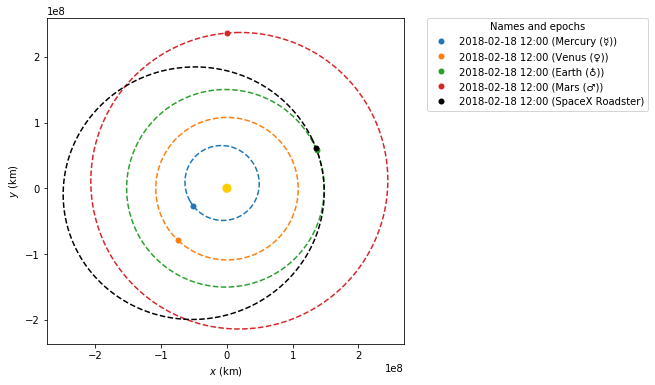

In [5]:
frame = plot_solar_system(outer=False, epoch=EPOCH)
frame.plot(roadster, label="SpaceX Roadster", color="black");

In [6]:
frame = OrbitPlotter3D()

frame.plot(Orbit.from_body_ephem(Earth, EPOCH), label=Earth)
frame.plot(Orbit.from_body_ephem(Mars, EPOCH), label=Mars)
frame.plot(roadster, label="SpaceX Roadster", color="black")

frame.set_view(30 * u.deg, -100 * u.deg, 2 * u.km)

/home/juanlu/Development/poliastro/poliastro-library/src/poliastro/twobody/orbit.py:1163: UserWarning:

Frame <class 'astropy.coordinates.builtin_frames.icrs.ICRS'> does not support 'obstime', time values were not returned

